HubSpot ML Framework - Comprehensive Demo & Technical Walkthrough
==================================================================

This notebook demonstrates:
1. Every module and its design patterns
2. How extensibility works
3. Why specific design choices were made
4. How to customize and extend the framework

In [3]:
# # HubSpot ML Framework: Complete Technical Walkthrough
# 
# ## Table of Contents
# 1. [Framework Overview & Architecture](#overview)
# 2. [Module 1: Configuration Management](#config)
# 3. [Module 2: Data Loading & Protocol Pattern](#data-loading)
# 4. [Module 3: Feature Engineering Pipeline](#feature-engineering)
# 5. [Module 4: Model Abstraction Layer](#models)
# 6. [Module 5: Training & Experiment Tracking](#training)
# 7. [Module 6: Model Serving & API](#serving)
# 8. [Extensibility Demonstrations](#extensibility)
# 9. [Design Patterns & Trade-offs](#design)

In [4]:
# ## 1. Framework Overview & Architecture 
#
# ### Key Design Principles
# 
# **Problem**: Data scientists need to rapidly iterate on ML models while maintaining:
# - Reproducibility
# - Code reusability
# - Easy extensibility
# - Production readiness
#
# **Solution**: A modular framework with clear abstractions
#
# ```
# ml_framework/
# ├── data/          → Protocol-based data loading (extensible to any source)
# ├── models/        → Abstract model interface (add new models easily)
# ├── training/      → MLflow-integrated training pipeline
# ├── serving/       → FastAPI production serving
# └── utils/         → Config, logging, metrics
# ```
#
# **Key Patterns Used**:
# - Protocol Classes (duck typing for flexibility)
# - Abstract Base Classes (enforced contracts)
# - Composition over Inheritance
# - Configuration-driven experiments


In [5]:
import sys
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Add src to path
sys.path.insert(0, '../src')

print("✓ Imports successful")
print(f"Working directory: {Path.cwd()}")

✓ Imports successful
Working directory: C:\Users\jahna\Downloads\Hubspot_Assesment\Hubspot_Assesment\ml-framework-package\notebooks


In [6]:
# ## 2. Configuration Management
#
# ### Why Configuration-Driven Design?
#
# **Problem**: Hard-coded parameters make experiments non-reproducible
# 
# **Solution**: YAML-based configuration with OmegaConf-style access
#
# **Benefits**:
# - All experiment parameters in one place
# - Easy to version control experiments
# - Can override via CLI or environment variables
# - Type-safe attribute access

In [7]:
from ml_framework.utils import load_config, Config

# Load the configuration
config = load_config('../configs/config.yaml')

print("=== Configuration Structure ===\n")
print(f"Experiment name: {config.experiment.name}")
print(f"Model type: {config.model.type}")
print(f"Model params: {config.model.hyperparameters}")
print(f"  - Customers: {config.data.customers_path}")
print(f"  - Non-customers: {config.data.noncustomers_path}")
print(f"  - Usage: {config.data.usage_actions_path}")


=== Configuration Structure ===

Experiment name: customer_conversion_baseline
Model type: logistic_regression
Model params: Config({'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 1000, 'class_weight': 'balanced'})
  - Customers: data/customers.csv
  - Non-customers: data/noncustomers.csv
  - Usage: data/usage_actions.csv


In [8]:
# Configuration is mutable - easy to override for experiments
print("\n=== Programmatic Configuration Override ===")
print(f"Original n_estimators: {config.model.hyperparameters.penalty}")

# Override for a new experiment - either here or config
config.model.hyperparameters.penalty = 'l1'
config.model.hyperparameters.max_iter = 15

print(f"Modified n_estimators: {config.model.hyperparameters.penalty}")
print(f"Modified max_depth: {config.model.hyperparameters.max_iter}")


=== Programmatic Configuration Override ===
Original n_estimators: l2
Modified n_estimators: l1
Modified max_depth: 15


In [9]:
# Reload fresh config
config = load_config('../configs/config.yaml')

In [10]:
# ## 3. Data Loading & Protocol Pattern <a id="data-loading"></a>
#
# ### Design Pattern: Protocol Classes (Duck Typing)
#
# **Problem**: Different data sources (CSV, database, API) need different implementations
#
# **Solution**: Define a Protocol that any data loader must implement
#
# **Why Protocol over Abstract Class?**
# - More flexible (duck typing)
# - No need to inherit from base class
# - Easy to mock for testing
# - Can work with any object that has the right methods
#
# **The Protocol**:
# ```python
# class DataLoader(Protocol):
#     def load_data(self) -> pd.DataFrame: ...
#     def get_features_and_target(self, df) -> Tuple[X, y]: ...
#     def load_and_prepare(self) -> Tuple[X, y]: ...
# ```
#
# Any class implementing these methods is a valid DataLoader!

In [11]:
config.data.customers_path

'data/customers.csv'

In [12]:
from ml_framework.data import HubSpotDataLoader

# Initialize data loader with quality checks
loader = HubSpotDataLoader(
    customers_path="../data/customers.csv",  
    noncustomers_path="../data/noncustomers.csv",
    usage_path="../data/usage_actions.csv",
    lookback_days=config.data.features.lookback_days,
    validate_schema=True,     
    profile_data=True,         
    handle_duplicates=True,     
    duplicate_strategy='most_complete'
)

print("=== Data Loader Initialized ===")
print(f"Type: {type(loader)}")
print(f"Implements DataLoader protocol: ✓")

=== Data Loader Initialized ===
Type: <class 'ml_framework.data.loaders.HubSpotDataLoader'>
Implements DataLoader protocol: ✓


In [13]:
# Load and merge all data sources
print("\n=== Loading Data with Quality Checks ===\n")
df = loader.load_data()

print(f"\n=== Final Dataset ===")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)[:10]}...")
print(f"\nFirst few rows:")
print(df.head(3))


=== Loading Data with Quality Checks ===




customers validation WARNINGS:
Found 4 customers (2.0%) with MRR ≤ 0 (pipeline will clean these)

noncustomers validation WARNINGS:
Soft uniqueness check failed for key ('id',): 3 duplicates found (acceptable but flagged)

⚠️  DUPLICATES FOUND: noncustomers
Found 6 duplicate rows for key=['id']
Unique IDs affected: 3
Strategy 'most_complete' will be applied.


Sample duplicate groups:
      id  _duplicate_group
446  278                 0
447  278                 0
922  279                 1
923  279                 1
443  280                 2
444  280                 2

🗑️  Removed 3 duplicate rows

Found 4 customers with MRR <= 0 (2.00%)
Business rule: Customers (is_customer = 1) must have MRR > 0

Sample invalid rows:
     id     MRR
2   118  -61.15
5   141 -403.20
6   197 -260.00
19    3 -555.00

🗑️  Removed 4 invalid customers



=== Final Dataset ===
Shape: (5196, 40)
Columns: ['CLOSEDATE', 'MRR', 'ALEXA_RANK', 'EMPLOYEE_RANGE', 'INDUSTRY', 'id', 'is_customer', 'ACTIONS_CRM_CONTACTS_sum', 'ACTIONS_CRM_CONTACTS_mean', 'ACTIONS_CRM_CONTACTS_max']...

First few rows:
    CLOSEDATE     MRR  ALEXA_RANK EMPLOYEE_RANGE           INDUSTRY   id  \
0  2019-06-20  290.00    309343.0    201 to 1000              Other  199   
1  2019-03-22  392.54  16000001.0      51 to 200                NaN  147   
2  2019-09-19  400.00   3575321.0    201 to 1000  CONSUMER_SERVICES  126   

   is_customer  ACTIONS_CRM_CONTACTS_sum  ACTIONS_CRM_CONTACTS_mean  \
0            1                    5438.0                  77.685714   
1            1                    6069.0                  94.828125   
2            1                    8574.0                 140.557377   

   ACTIONS_CRM_CONTACTS_max  ...  USERS_CRM_DEALS_mean  USERS_CRM_DEALS_max  \
0                     233.0  ...              0.528571                  3.0   
1          

In [14]:
print("\n=== Target Variable Distribution ===")
print(df['is_customer'].value_counts())
print(f"\nClass balance: {df['is_customer'].mean():.2%} are customers")


=== Target Variable Distribution ===
is_customer
0    5000
1     196
Name: count, dtype: int64

Class balance: 3.77% are customers


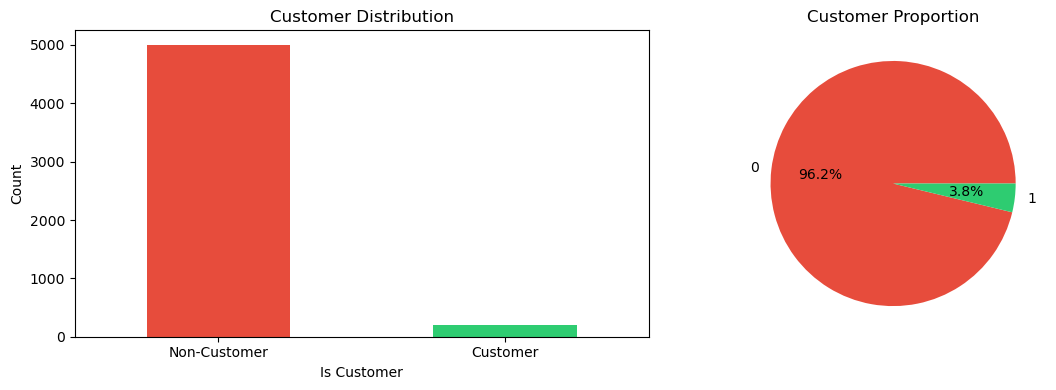

In [15]:
# Visualize
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Count plot
df['is_customer'].value_counts().plot(kind='bar', ax=ax[0], color=['#e74c3c', '#2ecc71'])
ax[0].set_title('Customer Distribution')
ax[0].set_xlabel('Is Customer')
ax[0].set_ylabel('Count')
ax[0].set_xticklabels(['Non-Customer', 'Customer'], rotation=0)

# Pie chart
df['is_customer'].value_counts().plot(kind='pie', ax=ax[1], autopct='%1.1f%%', 
                                       colors=['#e74c3c', '#2ecc71'])
ax[1].set_ylabel('')
ax[1].set_title('Customer Proportion')

plt.tight_layout()
plt.show()

In [16]:
# Split into features and target
# Dropped these ["id", "is_customer", "CLOSEDATE", "MRR"] as not useful for current framework
X, y = loader.get_features_and_target(df)

print(f"\n=== Features and Target ===")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns ({len(X.columns)} total):")
for i, col in enumerate(X.columns[:15], 1):
    print(f"  {i:2d}. {col}")
if len(X.columns) > 15:
    print(f"  ... and {len(X.columns) - 15} more")


=== Features and Target ===
Features shape: (5196, 36)
Target shape: (5196,)

Feature columns (36 total):
   1. ALEXA_RANK
   2. EMPLOYEE_RANGE
   3. INDUSTRY
   4. ACTIONS_CRM_CONTACTS_sum
   5. ACTIONS_CRM_CONTACTS_mean
   6. ACTIONS_CRM_CONTACTS_max
   7. ACTIONS_CRM_CONTACTS_std
   8. ACTIONS_CRM_COMPANIES_sum
   9. ACTIONS_CRM_COMPANIES_mean
  10. ACTIONS_CRM_COMPANIES_max
  11. ACTIONS_CRM_COMPANIES_std
  12. ACTIONS_CRM_DEALS_sum
  13. ACTIONS_CRM_DEALS_mean
  14. ACTIONS_CRM_DEALS_max
  15. ACTIONS_CRM_DEALS_std
  ... and 21 more


In [17]:
# ### Understanding the Usage Feature Engineering
#
# The `HubSpotDataLoader` automatically aggregates usage actions into meaningful features:
#
# **Raw Data**: Individual user actions over time
# ```
# id, WHEN_TIMESTAMP, ACTIONS_CRM_CONTACTS, USERS_CRM_CONTACTS, ...
# ```
#
# **Aggregated Features** (per company):
# - **Action aggregations**: sum, mean, max, std for each action type
# - **User aggregations**: sum, mean, max for unique users
# - **Derived features**:
#   - `total_actions`: Sum across all action types
#   - `total_users`: Total unique users
#   - `actions_per_user`: Engagement intensity
#   - `days_active`: Time span of activity
#   - `activity_frequency`: Actions per da

In [18]:
# Examine usage features
usage_cols = [col for col in X.columns if 'ACTIONS' in col or 'USERS' in col or 
              col in ['total_actions', 'total_users', 'actions_per_user', 'activity_frequency']]

print(f"\n=== Usage Features ({len(usage_cols)} features) ===")
for col in usage_cols[:10]:
    print(f"  - {col}")
    
# Show statistics for key derived features
derived_features = ['total_actions', 'total_users', 'actions_per_user', 'activity_frequency']
if all(f in X.columns for f in derived_features):
    print("\n=== Derived Feature Statistics ===")
    print(X[derived_features].describe())



=== Usage Features (32 features) ===
  - ACTIONS_CRM_CONTACTS_sum
  - ACTIONS_CRM_CONTACTS_mean
  - ACTIONS_CRM_CONTACTS_max
  - ACTIONS_CRM_CONTACTS_std
  - ACTIONS_CRM_COMPANIES_sum
  - ACTIONS_CRM_COMPANIES_mean
  - ACTIONS_CRM_COMPANIES_max
  - ACTIONS_CRM_COMPANIES_std
  - ACTIONS_CRM_DEALS_sum
  - ACTIONS_CRM_DEALS_mean

=== Derived Feature Statistics ===
       total_actions  total_users  actions_per_user  activity_frequency
count    5196.000000  5196.000000       5196.000000         5196.000000
mean      608.225751    22.210739          2.964521            0.327517
std      7182.405884   196.922256         16.533374            0.435779
min         0.000000     0.000000          0.000000            0.000000
25%         0.000000     0.000000          0.000000            0.000000
50%         0.000000     0.000000          0.000000            0.072383
75%         2.000000     1.000000          1.500000            1.000000
max    232023.000000  7695.000000        953.833333        

In [19]:
# ## 4. Feature Engineering Pipeline <a id="feature-engineering"></a>
#
# ### Design Pattern: Composable Transformers
#
# **Problem**: Different features need different transformations (encoding, scaling, etc.)
#
# **Solution**: Small, focused transformer classes that can be composed
#
# **Why this approach?**
# - Single Responsibility Principle
# - Easy to test individual transformers
# - Can compose in different orders
# - Clear separation of concerns
#
# **Transformers**:
# 1. `FeatureEngineer` - Main pipeline (scaling + encoding)
# 2. `EmployeeRangeOrdinalEncoder` - Domain-specific encoding
# 3. `IndustryEncoder` - Frequency-based one-hot encoding
# 4. `MissingValueHandler` - Intelligent imputation


In [20]:
from ml_framework.data import (
    FeatureEngineer,
    EmployeeRangeOrdinalEncoder,
    IndustryEncoder,
    MissingValueHandler
)
from sklearn.model_selection import train_test_split

# Split data first (important: fit only on train!)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=config.data.test_size,
    random_state=config.data.random_state,
    stratify=y
)

print(f"=== Train/Test Split ===")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Train class balance: {y_train.mean():.2%}")
print(f"Test class balance: {y_test.mean():.2%}")


=== Train/Test Split ===
Training set: (4156, 36)
Test set: (1040, 36)
Train class balance: 3.78%
Test class balance: 3.75%


In [21]:
# Step 1: Handle missing values
print("\n=== Step 1: Missing Value Handling ===")

missing_handler = MissingValueHandler(strategy='auto')
X_train_clean = missing_handler.fit_transform(X_train)
X_test_clean = missing_handler.transform(X_test)

print(f"Missing values before: {X_train.isnull().sum().sum()}")
print(f"Missing values after: {X_train_clean.isnull().sum().sum()}")




=== Step 1: Missing Value Handling ===
Missing values before: 3577
Missing values after: 0


In [22]:
print("\n=== Step 2: Employee Range Encoding ===")

if 'EMPLOYEE_RANGE' in X_train_clean.columns:
    print("Original EMPLOYEE_RANGE values:")
    print(X_train_clean['EMPLOYEE_RANGE'].value_counts().head())
    
    employee_encoder = EmployeeRangeOrdinalEncoder()
    X_train_clean = employee_encoder.transform(X_train_clean)
    X_test_clean = employee_encoder.transform(X_test_clean)
    
    print("\nEncoded to employee_range_ordinal:")
    print(X_train_clean['employee_range_ordinal'].value_counts().sort_index())
    print("\n✓ Ordinal encoding preserves company size ordering")



=== Step 2: Employee Range Encoding ===
Original EMPLOYEE_RANGE values:
EMPLOYEE_RANGE
2 to 5       1284
6 to 10       746
1             472
26 to 50      456
51 to 200     323
Name: count, dtype: int64

Encoded to employee_range_ordinal:
employee_range_ordinal
1     472
2    1284
3     746
4     297
5     456
6     323
7     261
8     283
9      34
Name: count, dtype: int64

✓ Ordinal encoding preserves company size ordering


In [23]:
# Step 3: Encode Industry (one-hot with frequency filtering)
print("\n=== Step 3: Industry Encoding ===")

if 'INDUSTRY' in X_train_clean.columns:
    print(f"Unique industries in training: {X_train_clean['INDUSTRY'].nunique()}")
    
    industry_encoder = IndustryEncoder(min_frequency=5)
    industry_encoder.fit(X_train_clean)
    
    print(f"Industries with >= 5 occurrences: {len(industry_encoder.top_industries)}")
    print(f"Top industries: {industry_encoder.top_industries[:5]}")
    
    X_train_clean = industry_encoder.transform(X_train_clean)
    X_test_clean = industry_encoder.transform(X_test_clean)
    
    industry_cols = [col for col in X_train_clean.columns if col.startswith('industry_')]
    print(f"\n✓ Created {len(industry_cols)} industry dummy variables")
    print(f"Examples: {industry_cols[:5]}")



=== Step 3: Industry Encoding ===
Unique industries in training: 161
Industries with >= 5 occurrences: 49
Top industries: ['COMPUTER_SOFTWARE', 'MARKETING_AND_ADVERTISING', 'HIGHER_EDUCATION', 'INFORMATION_TECHNOLOGY_AND_SERVICES', 'Non-Profit/Educational Institution']

✓ Created 49 industry dummy variables
Examples: ['industry_ACCOUNTING', 'industry_APPAREL_FASHION', 'industry_ARCHITECTURE_PLANNING', 'industry_AUTOMOTIVE', 'industry_BUILDING_MATERIALS']


In [24]:
# Step 4: Feature Engineering (scaling)
print("\n=== Step 4: Feature Scaling ===")

engineer = FeatureEngineer(
    scaling_method='standard',
    handle_categorical=True,exclude_from_scaling=['employee_range_ordinal']
)

X_train_scaled = engineer.fit_transform(X_train_clean)
X_test_scaled = engineer.transform(X_test_clean)

print(f"Final feature count: {X_train_scaled.shape[1]}")
print(f"\n✓ All features scaled to mean=0, std=1")

# Check scaling worked
numeric_cols = X_train_scaled.select_dtypes(include=[np.number]).columns[:5]
print("\nSample scaled features (first 5 numeric):")
print(X_train_scaled[numeric_cols].describe().loc[['mean', 'std']])




=== Step 4: Feature Scaling ===
Final feature count: 84

✓ All features scaled to mean=0, std=1

Sample scaled features (first 5 numeric):
        ALEXA_RANK  ACTIONS_CRM_CONTACTS_sum  ACTIONS_CRM_CONTACTS_mean  \
mean -5.983878e-17             -1.709679e-18               1.025808e-17   
std   1.000120e+00              1.000120e+00               1.000120e+00   

      ACTIONS_CRM_CONTACTS_max  ACTIONS_CRM_CONTACTS_std  
mean                   0.00000              1.538711e-17  
std                    1.00012              1.000120e+00  


In [25]:
# ### Why Fit/Transform Pattern?
#
# **Critical for ML**: Prevent data leakage!
#
# ```python
# # ✓ CORRECT
# encoder.fit(X_train)          # Learn parameters from training data only
# X_train = encoder.transform(X_train)
# X_test = encoder.transform(X_test)  # Apply same parameters to test
#
# # ✗ WRONG
# encoder.fit_transform(X_all)  # Leaks test set information!
# ```
#
# **What's stored during fit?**
# - Scaler: mean and std from training data
# - IndustryEncoder: top industries from training data
# - MissingValueHandler: median/mode values from training data

In [26]:
# ## 5. Model Abstraction Layer <a id="models"></a>
#
# ### Design Pattern: Protocol + Abstract Base Class
#
# **Problem**: Support multiple model types with consistent interface
#
# **Solution**: Two-layer abstraction
#
# 1. **Protocol** (interface): Defines what methods a model must have
# 2. **BaseModel** (ABC): Provides common functionality
#
# **Why both?**
# - Protocol: Allows using ANY model (even 3rd party) without modification
# - BaseModel: Provides helpful utilities for your own models
#
# **Benefits**:
# - Easy to add new models (just implement 3 methods)
# - Works with sklearn, xgboost, custom models
# - Consistent API for training pipeline



In [27]:
from ml_framework.models import (
    create_model,
    LogisticRegressionModel,
    RandomForestModel,
    XGBoostModel,
    LightGBMModel
)


In [28]:
# Create model using factory function
model = create_model(
    model_type=config.model.type,
    hyperparameters=config.model.hyperparameters.to_dict()
)

print(f"=== Model Creation ===")
print(f"Model type: {type(model).__name__}")
print(f"Model parameters: {model.get_params()}")
print(f"Is fitted: {model.is_fitted()}")


=== Model Creation ===
Model type: LogisticRegressionModel
Model parameters: {'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Is fitted: False


In [29]:
# Train the model
print("\n=== Training Model ===")

model.fit(X_train_scaled.values, y_train.values)

print(f"✓ Model trained successfully")
print(f"Is fitted: {model.is_fitted()}")



=== Training Model ===
✓ Model trained successfully
Is fitted: True


In [30]:
# Make predictions
y_pred = model.predict(X_test_scaled.values)
y_proba = model.predict_proba(X_test_scaled.values)

print(f"\n=== Predictions ===")
print(f"Predictions shape: {y_pred.shape}")
print(f"Probabilities shape: {y_proba.shape}")
print(f"\nSample predictions:")
print(pd.DataFrame({
    'True Label': y_test.values[:10],
    'Prediction': y_pred[:10],
    'Prob Class 0': y_proba[:10, 0].round(3),
    'Prob Class 1': y_proba[:10, 1].round(3)
}))




=== Predictions ===
Predictions shape: (1040,)
Probabilities shape: (1040, 2)

Sample predictions:
   True Label  Prediction  Prob Class 0  Prob Class 1
0           0           0         0.969         0.031
1           0           0         0.977         0.023
2           0           0         0.963         0.037
3           0           0         0.993         0.007
4           0           0         0.955         0.045
5           0           1         0.373         0.627
6           0           0         0.952         0.048
7           0           0         0.977         0.023
8           0           0         0.947         0.053
9           0           0         0.969         0.031



=== Top 15 Most Important Features ===
                                     feature  importance
                industry_Consulting/Advisory    1.987328
                         industry_ACCOUNTING    1.658099
                         USERS_CRM_DEALS_max    1.624883
                    ACTIONS_CRM_CONTACTS_std    1.372482
               industry_EDUCATION_MANAGEMENT    1.167052
                      USERS_CRM_CONTACTS_max    0.992276
industry_INFORMATION_TECHNOLOGY_AND_SERVICES    0.983742
                         USERS_CRM_DEALS_sum    0.981827
                           ACTIONS_EMAIL_max    0.962124
                  industry_COMPUTER_SOFTWARE    0.957803
                     USERS_CRM_COMPANIES_sum    0.806695
                   industry_HIGHER_EDUCATION    0.805870
                      ACTIONS_CRM_DEALS_mean    0.767185
                         industry_PUBLISHING    0.756379
                                  ALEXA_RANK    0.756371


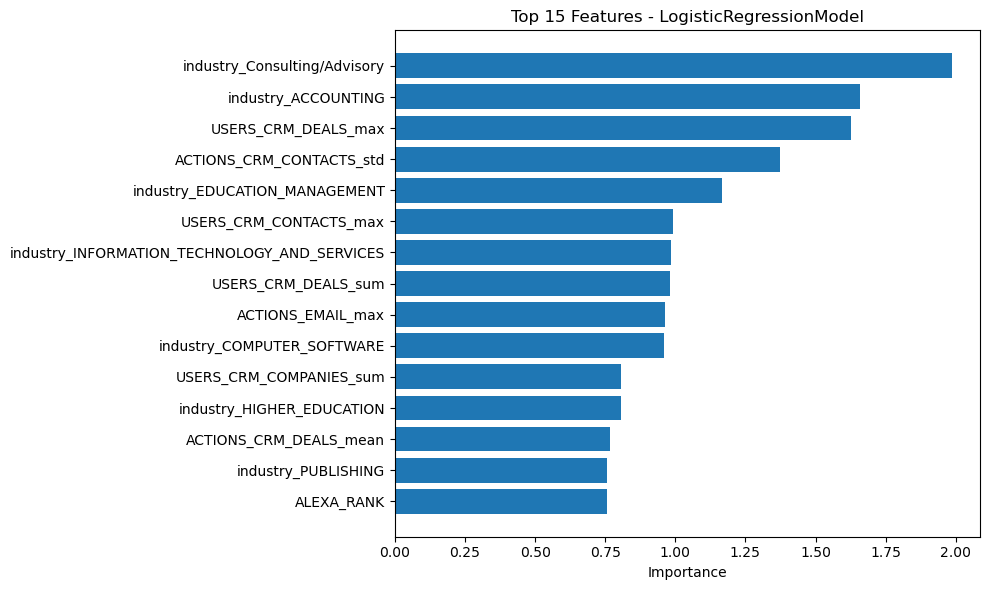

In [31]:
# Feature importance (if available)
try:
    importance = model.get_feature_importance()
    
    # Create importance dataframe
    importance_df = pd.DataFrame({
        'feature': X_train_scaled.columns,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    print(f"\n=== Top 15 Most Important Features ===")
    print(importance_df.head(15).to_string(index=False))
    
    # Visualize
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df.head(15)['feature'], importance_df.head(15)['importance'])
    plt.xlabel('Importance')
    plt.title(f'Top 15 Features - {type(model).__name__}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
except NotImplementedError:
    print(f"\n{type(model).__name__} does not support feature importance")


In [32]:
# ### Adding a Custom Model
#
# **How easy is it to add a new model?** Very easy!
#
# ```python
# from ml_framework.models import BaseModel
#
# class MyCustomModel(BaseModel):
#     def __init__(self, **kwargs):
#         super().__init__()
#         self.model = MyUnderlyingModel(**kwargs)
#     
#     def fit(self, X, y):
#         self.model.fit(X, y)
#         self._is_fitted = True
#         return self
#     
#     def predict(self, X):
#         return self.model.predict(X)
# ```
#
# That's it! Now it works with the entire training pipeline.

In [33]:
# ## 6. Training & Experiment Tracking <a id="training"></a>
#
# ### MLflow Integration
#
# **Problem**: Hard to track experiments, compare models, reproduce results
#
# **Solution**: MLflow for experiment tracking
#
# **What gets logged**:
# - Parameters (model hyperparameters, data config)
# - Metrics (accuracy, F1, AUC)
# - Artifacts (model file, feature names, plots)
# - Code version (git commit)
#
# **Benefits**:
# - Compare experiments in UI
# - Reproducible: all info to recreate experiment
# - Easy model deployment (load by run_id)



In [34]:
import mlflow
from pathlib import Path
import os

if Path.cwd().name == "notebooks":
    os.chdir(Path.cwd().parent)
    print(f"✓ Changed directory to project root: {Path.cwd()}")

# Set MLflow tracking URI to project root mlruns
mlflow.set_tracking_uri("mlruns")
print(f"✓ MLflow tracking URI: {mlflow.get_tracking_uri()}")

✓ Changed directory to project root: C:\Users\jahna\Downloads\Hubspot_Assesment\Hubspot_Assesment\ml-framework-package
✓ MLflow tracking URI: mlruns


In [35]:
from ml_framework.training import Trainer, Evaluator
from ml_framework.utils import MetricsCalculator, print_metrics_summary
# Create trainer (handles entire pipeline)
trainer = Trainer(config)

print("=== Trainer Initialized ===")
print(f"Experiment: {config.experiment.name}")
print(f"Tracking URI: {config.experiment.mlflow_tracking_uri}")


2025-11-13 07:39:24 - experiment.customer_conversion_baseline - INFO - Experiment 'customer_conversion_baseline' initialized
2025-11-13 07:39:24 - experiment.customer_conversion_baseline - INFO - Set random seed: 42
2025-11-13 07:39:24 - experiment.customer_conversion_baseline - INFO - MLflow tracking URI: mlruns
2025-11-13 07:39:24 - experiment.customer_conversion_baseline - INFO - MLflow experiment: customer_conversion_baseline
2025-11-13 07:39:24 - experiment.customer_conversion_baseline - INFO - Artifact directory: artifacts\customer_conversion_baseline_20251113_073924
2025-11-13 07:39:24 - experiment.customer_conversion_baseline - INFO - Trainer initialized for experiment: customer_conversion_baseline
=== Trainer Initialized ===
Experiment: customer_conversion_baseline
Tracking URI: mlruns


In [36]:
# Train with full pipeline
print("\n=== Running Full Training Pipeline ===\n")

results = trainer.train()

print(f"\n=== Training Results ===")
print(f"\nMetrics:")
for metric, value in results['metrics'].items():
    print(f"  {metric}: {value:.4f}")

# ============================================
# VERIFY RUN LOCATION
# ============================================
print(f"\n✓ Run saved to experiment: {config.experiment.name}")


=== Running Full Training Pipeline ===

2025-11-13 07:39:24 - experiment.customer_conversion_baseline - INFO - ============================================================
2025-11-13 07:39:24 - experiment.customer_conversion_baseline - INFO - Starting experiment: customer_conversion_baseline
2025-11-13 07:39:24 - experiment.customer_conversion_baseline - INFO - ============================================================
2025-11-13 07:39:24 - experiment.customer_conversion_baseline - INFO - Loading data from configured paths...
2025-11-13 07:39:24 - experiment.customer_conversion_baseline - INFO - Loading data...



customers validation WARNINGS:
Found 4 customers (2.0%) with MRR ≤ 0 (pipeline will clean these)

noncustomers validation WARNINGS:
Soft uniqueness check failed for key ('id',): 3 duplicates found (acceptable but flagged)

⚠️  DUPLICATES FOUND: noncustomers
Found 6 duplicate rows for key=['id']
Unique IDs affected: 3
Strategy 'most_complete' will be applied.


Sample duplicate groups:
      id  _duplicate_group
446  278                 0
447  278                 0
922  279                 1
923  279                 1
443  280                 2
444  280                 2

🗑️  Removed 3 duplicate rows

Found 4 customers with MRR <= 0 (2.00%)
Business rule: Customers (is_customer = 1) must have MRR > 0

Sample invalid rows:
     id     MRR
2   118  -61.15
5   141 -403.20
6   197 -260.00
19    3 -555.00

🗑️  Removed 4 invalid customers


2025-11-13 07:39:24 - experiment.customer_conversion_baseline - INFO - Loaded data: 5196 samples, 36 features
2025-11-13 07:39:24 - experiment.customer_conversion_baseline - INFO - Parameter - n_samples: 5196
2025-11-13 07:39:24 - experiment.customer_conversion_baseline - INFO - Parameter - n_features: 36
2025-11-13 07:39:24 - experiment.customer_conversion_baseline - INFO - Parameter - n_customers: 196
2025-11-13 07:39:24 - experiment.customer_conversion_baseline - INFO - Parameter - n_noncustomers: 5000
2025-11-13 07:39:24 - experiment.customer_conversion_baseline - INFO - Splitting data...
2025-11-13 07:39:24 - experiment.customer_conversion_baseline - INFO - Train: 4156 samples, Test: 1040 samples
2025-11-13 07:39:24 - experiment.customer_conversion_baseline - INFO - Parameter - train_size: 4156
2025-11-13 07:39:24 - experiment.customer_conversion_baseline - INFO - Parameter - test_size: 1040
2025-11-13 07:39:24 - experiment.customer_conversion_baseline - INFO - Preprocessing data 

C:\Users\jahna\anaconda3\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


2025-11-13 07:39:41 - experiment.customer_conversion_baseline - INFO - MLflow Run ID: dd1c5c98d8434e3496c32e0acf9a0be2
2025-11-13 07:39:41 - experiment.customer_conversion_baseline - INFO - ============================================================
2025-11-13 07:39:41 - experiment.customer_conversion_baseline - INFO - Experiment complete!
2025-11-13 07:39:41 - experiment.customer_conversion_baseline - INFO - ============================================================

=== Training Results ===

Metrics:
  accuracy: 0.9442
  precision: 0.3827
  recall: 0.7949
  f1: 0.5167
  roc_auc: 0.9510
  average_precision: 0.6449

✓ Run saved to experiment: customer_conversion_baseline


Registered model 'customer_conversion_baseline_model' already exists. Creating a new version of this model...
Created version '8' of model 'customer_conversion_baseline_model'.


In [37]:
type(y_test)

pandas.core.series.Series

In [38]:
# Evaluate in detail
from ml_framework.training import Evaluator

evaluator = Evaluator(
    model=model,
    config=config,
    artifact_dir=results['artifact_dir']
)

metrics = evaluator.evaluate(X_test_scaled, y_test)

print("\n=== Detailed Evaluation ===")

for metric_name, value in metrics.items():
    if isinstance(value, (int, float)):  # Only print numeric values
        print(f"{metric_name:20s}: {value:.4f}")
    elif metric_name == 'classification_report':
        print(f"\n{metric_name}:")
        print(value)


MODEL PERFORMANCE METRICS
ACCURACY...................... 0.9375
PRECISION..................... 0.3556
RECALL........................ 0.8205
F1............................ 0.4961
ROC_AUC....................... 0.9577
AVERAGE_PRECISION............. 0.6636


=== Detailed Evaluation ===

classification_report:
              precision    recall  f1-score   support

Non-Customer       0.99      0.94      0.97      1001
    Customer       0.36      0.82      0.50        39

    accuracy                           0.94      1040
   macro avg       0.67      0.88      0.73      1040
weighted avg       0.97      0.94      0.95      1040



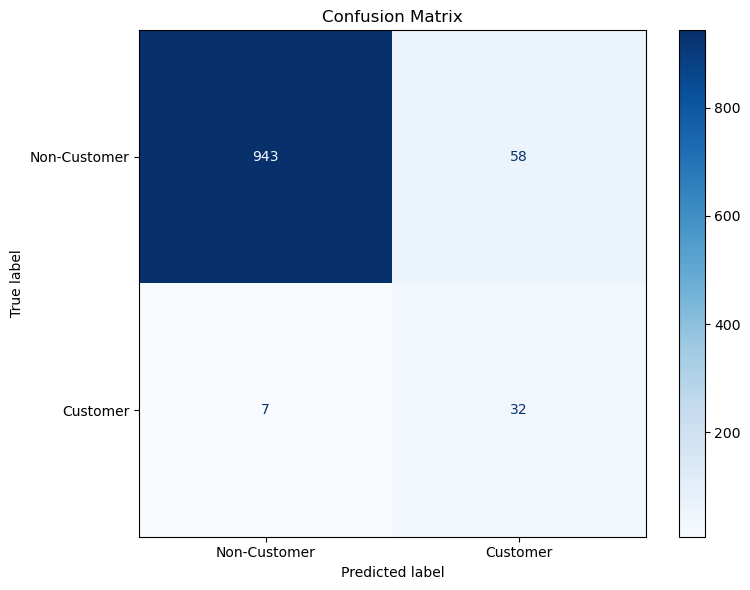


True Negatives (correctly identified non-customers): 943
False Positives (incorrectly flagged as customers): 58
False Negatives (missed customers): 7
True Positives (correctly identified customers): 32


In [39]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Customer', 'Customer'])
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

print(f"\nTrue Negatives (correctly identified non-customers): {cm[0, 0]}")
print(f"False Positives (incorrectly flagged as customers): {cm[0, 1]}")
print(f"False Negatives (missed customers): {cm[1, 0]}")
print(f"True Positives (correctly identified customers): {cm[1, 1]}")

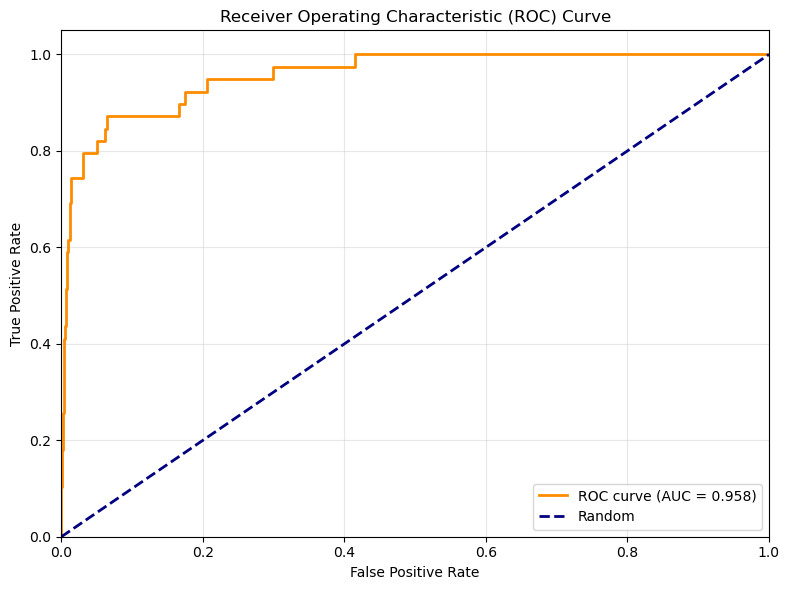

AUC-ROC: 0.9577

Interpretation:
  - AUC = 1.0: Perfect classifier
  - AUC = 0.5: Random guessing
  - AUC > 0.7: Generally acceptable
  - AUC > 0.8: Good performance
  - AUC > 0.9: Excellent performance


In [40]:
# ROC Curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"AUC-ROC: {roc_auc:.4f}")
print(f"\nInterpretation:")
print(f"  - AUC = 1.0: Perfect classifier")
print(f"  - AUC = 0.5: Random guessing")
print(f"  - AUC > 0.7: Generally acceptable")
print(f"  - AUC > 0.8: Good performance")
print(f"  - AUC > 0.9: Excellent performance")


In [41]:
# ### Viewing MLflow UI
#
# To view all your experiments:
#
# ```bash
# mlflow ui --backend-store-uri ./mlruns
# ```
#
# Then open: http://localhost:5000
#
# You can:
# - Compare multiple runs
# - Filter by metrics
# - Download artifacts
# - Load models by run_id


In [42]:
# ## 7. Model Serving & API <a id="serving"></a>
#
# ### FastAPI Production Serving
#
# **Problem**: Need to deploy models as API endpoints
#
# **Solution**: FastAPI with automatic validation
#
# **Architecture**:
# ```
# FastAPI Server
#    ↓
# Predictor (loads model + preprocessor)
#    ↓
# Make predictions
# ```
#
# **Benefits**:
# - Automatic request validation (Pydantic)
# - Interactive docs (Swagger UI)
# - Type safety
# - Async support



In [66]:
os.getcwd()

'C:\\Users\\jahna\\Downloads\\Hubspot_Assesment\\Hubspot_Assesment\\ml-framework-package'

In [76]:
from ml_framework.serving import Predictor

# Load the entire model + all preprocessors from artifact directory
predictor = Predictor.from_artifact_dir(
    "artifacts/customer_conversion_baseline_20251113_073924"
)

In [111]:
from ml_framework.serving import Predictor

# Load trained model
predictor = Predictor.from_artifact_dir(
    "artifacts/customer_conversion_baseline_20251113_073924"
)

print("=== Predictor Loaded ===")
print(f"Artifact dir: {results['artifact_dir']}")
# Make predictions on test data
predictions = predictor.predict(X_test)

print(f"\n=== Predictions ===")
print(predictions.head())

=== Predictor Loaded ===
Artifact dir: artifacts\customer_conversion_baseline_20251113_073924

=== Predictions ===
   prediction  probability  confidence
0           0     0.022566    0.977434
1           0     0.021550    0.978450
2           0     0.039094    0.960906
3           0     0.008328    0.991672
4           0     0.029645    0.970355


In [125]:
from ml_framework.serving import Predictor
import pandas as pd

# Load predictor
predictor = Predictor.from_artifact_dir(results['artifact_dir'])

# Add an ID column to your test data
X_test_with_id = X_test.copy()
X_test_with_id['company_id'] = range(1, len(X_test) + 1)

# Get a single sample WITH ID
single_sample_with_id = X_test_with_id.iloc[0:1].copy()

print(f"\n=== Single Prediction with ID ===")

# For prediction with ID - use predict_with_ids
prediction = predictor.predict_with_ids(single_sample_with_id, id_column='company_id')

print(f"\nCompany ID: {prediction['company_id'].iloc[0]}")
print(f"Prediction: {'Customer' if prediction['prediction'].iloc[0] == 1 else 'Non-Customer'}")
print(f"Probability: {prediction['probability'].iloc[0]:.2%}")
print(f"Confidence: {prediction['confidence'].iloc[0]:.2%}")

# For explanation - remove ID column first
single_sample_no_id = single_sample_with_id.drop('company_id', axis=1)

# Explain Prediction
explanation = predictor.explain_prediction(single_sample_no_id)

print(f"\n🔍 Explanation:")
print(f"  Prediction: {explanation['prediction']} ({'Customer' if explanation['prediction'] == 1 else 'Non-Customer'})")
print(f"  Probability: {explanation['probability']:.2%}")

if explanation['top_features']:
    print(f"\n📈 Top 5 Most Important Features:")
    for rank, feature in enumerate(explanation['top_features'][:5], 1):
        value = single_sample_no_id[feature['feature']].iloc[0]
        print(f"  {rank}. {feature['feature']:<40} = {value}")
        print(f"      Importance: {feature['importance']:.6f}")


=== Single Prediction with ID ===

Company ID: 1
Prediction: Non-Customer
Probability: 8.84%
Confidence: 91.16%

🔍 Explanation:
  Prediction: 0 (Non-Customer)
  Probability: 8.84%


In [120]:
# Option 1: If your test data has an index that represents IDs
X_test_with_ids = X_test.copy()
X_test_with_ids['company_id'] = X_test.index

# Option 2: Create meaningful IDs (e.g., starting from 10000)
X_test_with_ids = X_test.copy()
X_test_with_ids['company_id'] = range(10000, 10000 + len(X_test))

# Get top prospects
top_prospects = predictor.get_top_prospects(
    X_test_with_ids,
    n=100,
    id_column='company_id'
)

print("\n=== Top 100 Prospects Most Likely to Convert ===")
print(top_prospects[['company_id', 'prediction', 'probability', 'confidence']].head(10))


=== Top 100 Prospects Most Likely to Convert ===
     company_id  prediction  probability  confidence
601       10601           1     1.000000    1.000000
925       10925           1     1.000000    1.000000
131       10131           1     1.000000    1.000000
603       10603           1     1.000000    1.000000
633       10633           1     0.999999    0.999999
577       10577           1     0.999996    0.999996
335       10335           1     0.999946    0.999946
287       10287           1     0.999913    0.999913
122       10122           1     0.999890    0.999890
308       10308           1     0.999731    0.999731


In [93]:
import joblib
loaded_object = joblib.load('artifacts/customer_conversion_baseline_20251113_073924/models/feature_engineer.joblib')

In [103]:
print(f"\nType: {type(loaded_object).__name__}")


Type: FeatureEngineer


In [105]:
print(f"\nAttributes:")
for attr in dir(loaded_object):
    if not attr.startswith('_'):
        value = getattr(loaded_object, attr)
        if not callable(value):
            print(f"  {attr}: {value}")


Attributes:
  categorical_features: ['industry_ACCOUNTING', 'industry_APPAREL_FASHION', 'industry_ARCHITECTURE_PLANNING', 'industry_AUTOMOTIVE', 'industry_BUILDING_MATERIALS', 'industry_COMPUTER_SOFTWARE', 'industry_CONSTRUCTION', 'industry_CONSUMER_ELECTRONICS', 'industry_CONSUMER_GOODS', 'industry_CONSUMER_SERVICES', 'industry_Consulting/Advisory', 'industry_Consumer Products', 'industry_DESIGN', 'industry_EDUCATION_MANAGEMENT', 'industry_ELECTRICAL_ELECTRONIC_MANUFACTURING', 'industry_ENTERTAINMENT', 'industry_ENVIRONMENTAL_SERVICES', 'industry_Education', 'industry_FINANCIAL_SERVICES', 'industry_FOOD_BEVERAGES', 'industry_Finance and Insurance', 'industry_GOVERNMENT_ADMINISTRATION', 'industry_HEALTH_WELLNESS_AND_FITNESS', 'industry_HIGHER_EDUCATION', 'industry_HOSPITALITY', 'industry_HOSPITAL_HEALTH_CARE', 'industry_IMPORT_AND_EXPORT', 'industry_INFORMATION_TECHNOLOGY_AND_SERVICES', 'industry_INSURANCE', 'industry_LEISURE_TRAVEL_TOURISM', 'industry_MANAGEMENT_CONSULTING', 'industr

In [131]:
import requests
requests.get("http://localhost:8000/health").json()

{'status': 'healthy', 'model_loaded': True, 'model_version': '1.0.0'}